Let's set up a Pavolovian conditioning experiment.

Agent A

Sensory input
* Vision: 10 bit vector. A specific sparse pattern indicates sight of food.
* Taste: 10 bit vector. A specific sparse pattern indicates taste of food.

Among uncorrelated sensory activity, the following pattern is hidden.

* Taste of food -- time delay t1 --> reward

Would this agent associate high reward prediction for Taste of food?

Later, the following pattern is presented.

* Sight of food --- time delay t0 --> Taste of food --- time delay t1 --> reward

Would the agent now associate high reward prediction for Sight of food? Will it stop associating Taste with reward (as seen from animal studies)?

* Each modality gets a layer Lm
* A corss-modal layer has neurons with RF from each Lm layer.
* Exc and inh lateral connectivity

## New
* Single modality for now
* Replay buffer (input_t1, activation_t1-1, activation_t2), where t1 < t2 are dt apart and the network learns to produce activation_t2 when showing input_t1, with activation_t1-1 as context.


## Remarks
* Still trying to work out the training procedure. How to train only during high reward periods?
* Stacked layers produce "flat" looking activations, making is harder to train using attractor learning which relies on activation values
* Attractor learning is similar to Q learning and that connection needs to be explored.

In [0]:
import logging
import numpy as np
import os
import random
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Bernoulli
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
plt.style.use('classic')

def reset_random(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

data_trace[taste] torch.Size([4490, 5])


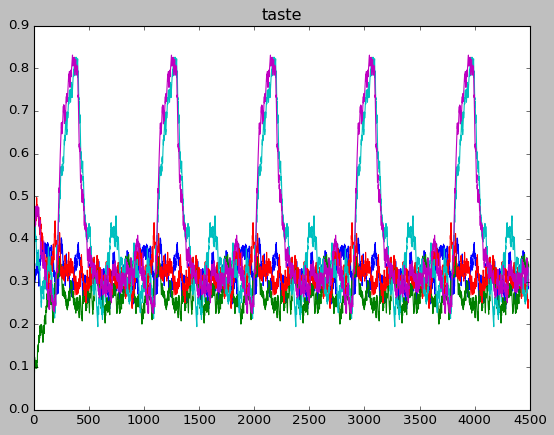

data_trace[reward] torch.Size([4490, 4])


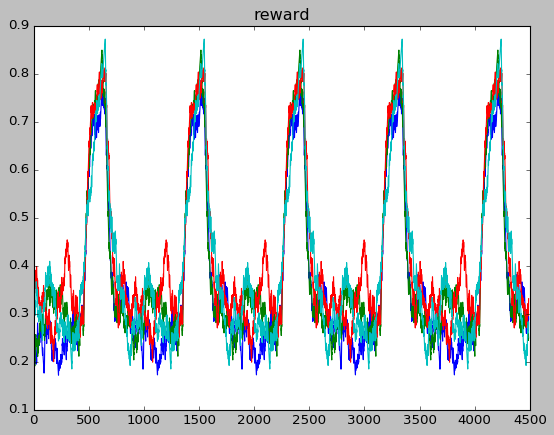

In [96]:
VISION_SIZE = 10
TASTE_SIZE = 5
REWARD_SIZE = 4

BASELINE_ACTIVATION = B = 0.3
HIGH_ACTIVATION = H = 0.8

reset_random()

class SpatialPattern:
  def __init__(self, values):
    self.poisson = Bernoulli(probs=values)

  def sample(self, shape):
    return self.poisson.sample(shape)

class TemporalPattern:
  def __init__(self, config):
    self.config = config
    
  def sample(self):
    all_samples = {}
    
    for modality_name, modality_config in self.config.items():
      modality_samples = torch.cat([row[2].sample([row[1] - row[0]]) for row in modality_config])
      all_samples[modality_name] = modality_samples

    return all_samples
    
class SensoryModality:      
  def __init__(self, name, size, baseline_activation):
    self.name = name
    self.baseline_pattern = SpatialPattern(torch.ones(size) * baseline_activation)
    
  def baseline_sample(self, shape):
    return self.baseline_pattern.sample(shape)
  
  def create_spatial_pattern(self, values):
    return SpatialPattern(torch.tensor(values))

def trace(data, decay_rate=0.98):
  trace = data[0:30].mean(dim=0)
  data_trace = []

  for i in range(data.shape[0]):
    row = data[i]
    trace = trace * decay_rate + row * (1 - decay_rate)
    data_trace.append(trace)

  data_trace = torch.stack(data_trace)
  #print(data_trace)

  return data_trace


taste = SensoryModality("taste", TASTE_SIZE, BASELINE_ACTIVATION)
reward = SensoryModality("reward", REWARD_SIZE, BASELINE_ACTIVATION)

modalities = [taste, reward]

experiment1 = TemporalPattern(
  {
    taste.name: [
      [0,  200, taste.baseline_pattern],
      [201, 400, taste.create_spatial_pattern([B,B,B,H,H])],
      [401, 900, taste.baseline_pattern],
    ],
    reward.name: [
      [0,  450, reward.baseline_pattern],
      [451, 650, reward.create_spatial_pattern([H,H,H,H])],
      [651, 900, reward.baseline_pattern],
    ]
  }
)

data = experiment1.sample()

data_trace = {}
for modality in modalities:
  d = data[modality.name]
  d = torch.stack([d for _ in range(5)]).view(-1, d.shape[-1])

  data_trace[modality.name] = trace(d)
  print(f"data_trace[{modality.name}] {data_trace[modality.name].shape}")
  plt.plot(data_trace[modality.name].numpy())
  plt.title(modality.name)
  plt.show()



In [102]:
reset_random()

class LocalEnsemble(nn.Module):
  def __init__(self, input_size, ensemble_size):
    super(LocalEnsemble, self).__init__()
    
    self.logger = logging.getLogger(self.__class__.__name__)
    self.logger.setLevel(logging.DEBUG)

    self.input_size = input_size

    self.ensemble = nn.Linear(input_size, ensemble_size)

    self.initialize_sparse_weights(self.ensemble)
    
    self.lateral_excitatory = nn.Linear(ensemble_size, ensemble_size)
    self.initialize_sparse_weights(self.lateral_excitatory)

    self.lateral_inhibitory = nn.Linear(ensemble_size, ensemble_size)
    self.initialize_sparse_weights(self.lateral_inhibitory)


    self.previous_activation = torch.zeros(ensemble_size)
    
  def initialize_sparse_weights(self, layer):
    layer.weight.data = F.dropout(layer.weight.data, 0.3)
    self.normalize_weights(layer)    
    
  def normalize_weights(self, layer):
    layer.weight.data[layer.weight.data < 0] = 0
    den = layer.weight.data.sum(dim=1)
    den[den < 0.0001] = 1
    layer.weight.data = layer.weight.data / den[:, None]

  def forward(self, x):
    afferent_activation = self.ensemble(x)
    lateral_excitatory_activation = torch.tanh(self.lateral_excitatory(self.previous_activation))
    lateral_inhibitory_activation = torch.tanh(self.lateral_inhibitory(self.previous_activation))
    
    activation = torch.sigmoid(afferent_activation + lateral_excitatory_activation - lateral_inhibitory_activation)
    
    self.previous_activation = activation
    return activation

class LocalEnsembleStack(nn.Module):
  def __init__(self, input_size, ensemble_size):
    super(LocalEnsembleStack, self).__init__()
    self.ensemble1 = LocalEnsemble(input_size, ensemble_size)
    self.ensemble2 = LocalEnsemble(ensemble_size, ensemble_size)
    
  def forward(self, x):
    return self.ensemble2(self.ensemble1(x))

modality_models = {}
for modality in modalities:
  dt = data_trace[modality.name]
  print(f"data_trace[{modality.name}]", data_trace[modality.name].shape)

  modality_models[modality.name] = model = LocalEnsembleStack(dt.shape[-1], 10)
  model.forward(dt) # burner


data_trace[taste] torch.Size([4490, 5])
data_trace[reward] torch.Size([4490, 4])


data_trace[taste] torch.Size([4490, 5])
activations torch.Size([4490, 10])


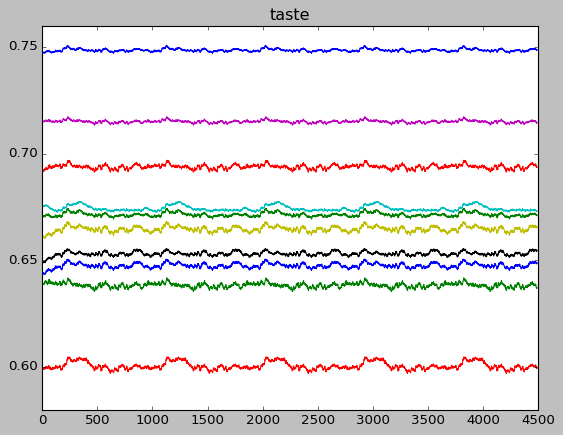

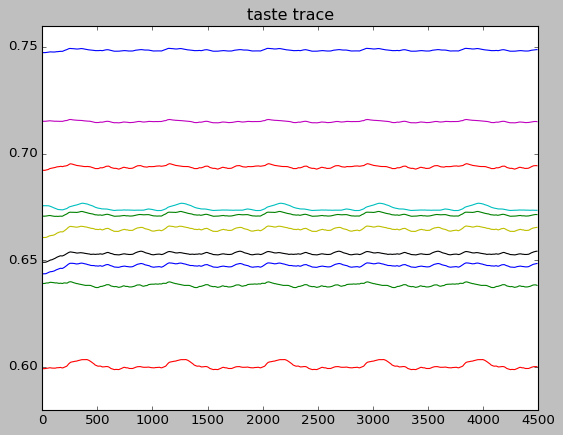

data_trace[reward] torch.Size([4490, 4])
activations torch.Size([4490, 10])


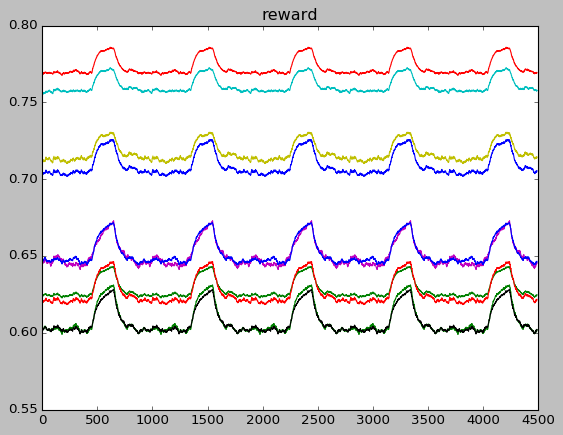

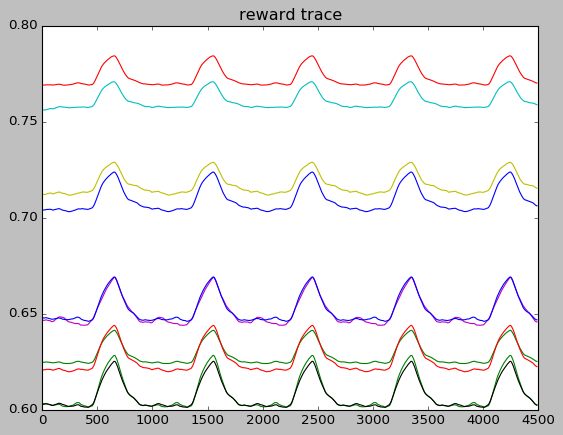

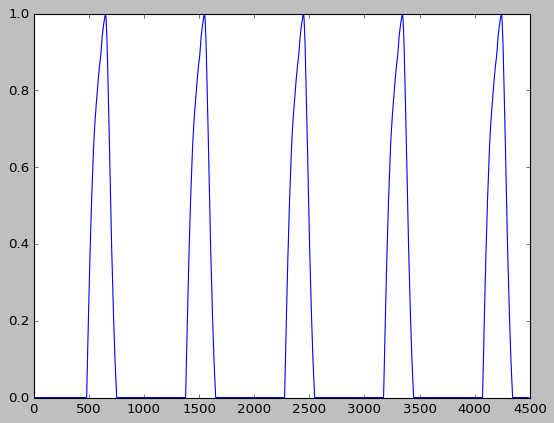

In [103]:
reset_random()

original_activations = None
reward_activations = None

for modality in modalities:
  model = modality_models[modality.name]
  activations = model.forward(data_trace[modality.name])
  if modality.name == 'reward':
    reward_activations = activations
  elif modality.name == 'taste':
    original_activations = activations

  print(f"data_trace[{modality.name}]", data_trace[modality.name].shape)
  print("activations", activations.shape)

  #activations = torch.stack(activations)
  # trace(activation.detach())
  #activations = activations.view(-1, activations.shape[-1])
  #plt.plot(trace(activations.detach()).numpy())
  plt.plot(activations.detach().numpy())
  plt.title(modality.name)
  plt.show()
  plt.plot(trace(activations.detach()).numpy())
  plt.title(f"{modality.name} trace")
  plt.show()

total_reward_trace = trace(reward_activations, decay_rate=0.96).mean(dim=1)
total_reward_trace = total_reward_trace - total_reward_trace.mean(dim=0)
m = total_reward_trace.max(dim=0)[0]
total_reward_trace = total_reward_trace / m
total_reward_trace[total_reward_trace < 0] = 0
plt.plot(total_reward_trace.detach().numpy())
plt.show()

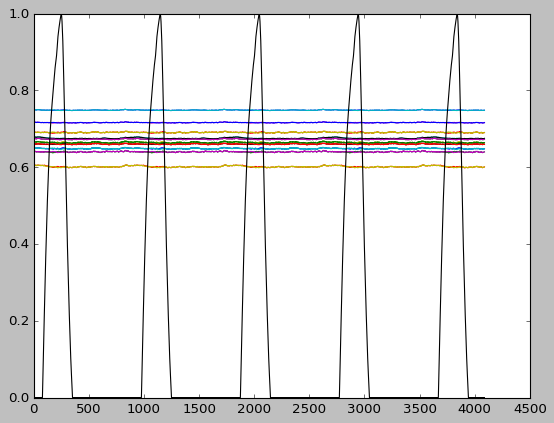

data_trace[reward] torch.Size([4490, 4])
target_activations torch.Size([4490, 10])
Loss: 3.0605926326643385e-07


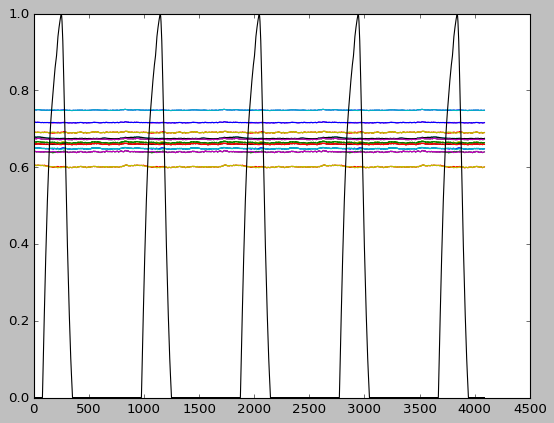

KeyboardInterrupt: ignored

In [105]:
reset_random()

dt = 100
skip_initial = 300
modality_name = "taste"
target_activations = modality_models[modality_name].forward(data_trace[modality_name]).detach()

reward_t2 = total_reward_trace[skip_initial+1+dt:]
activation_t1 = target_activations[skip_initial+1:-dt]
activation_t2 = target_activations[skip_initial+1+dt:]
activation_t2 = activation_t2 * reward_t2[:, None] + activation_t1 * (1 - reward_t2[:, None])
input_t1 = data_trace[modality_name][skip_initial+1:-dt]

plt.plot(activation_t1.detach().numpy())
plt.plot(activation_t2.detach().numpy())
plt.plot(reward_t2.detach().numpy())

plt.show()


print(f"data_trace[{modality.name}]", data_trace[modality.name].shape)
print("target_activations", target_activations.shape)

#optimizer = optim.Adam(modality_models[modality_name].parameters(), lr=0.1)
optimizer = optim.SGD(modality_models[modality_name].parameters(), lr=0.01)

n_steps = 5000
for step in range(n_steps):
  modality_models[modality_name].previous_activation = target_activations[0]
  activations = modality_models[modality_name].forward(data_trace[modality_name])

  activation_t1 = activations[skip_initial+1:-dt]

  optimizer.zero_grad()
  loss = F.mse_loss(activation_t2, activation_t1)
  #loss = (activation_t2 - activation_t1) ** 2
  #loss = (loss * reward_t2[:, None]).mean()
  #loss = loss.mean()
  loss.backward(retain_graph=True)
  optimizer.step()
  

  if step % int(n_steps/10) == 0:
    print(f"Loss: {loss.item()}")
    plt.plot(activation_t1.detach().numpy())
    plt.plot(activation_t2.detach().numpy())
    plt.plot(reward_t2.detach().numpy())

    plt.show()

  

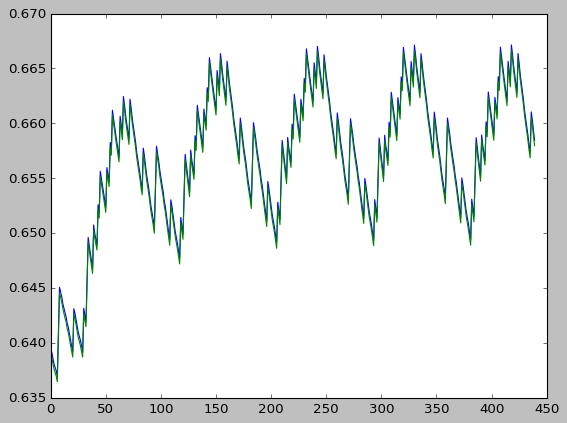

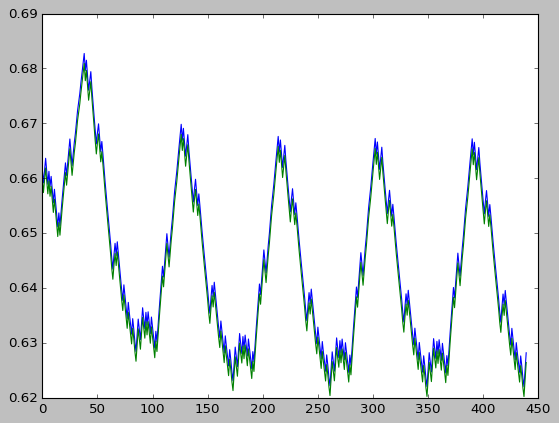

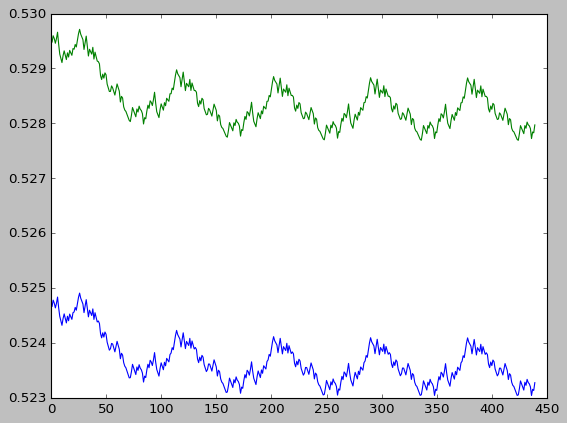

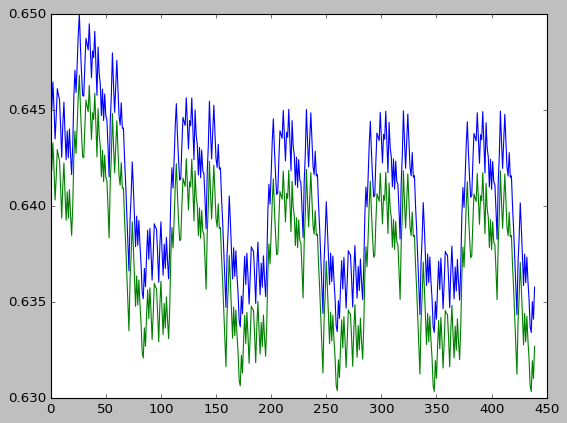

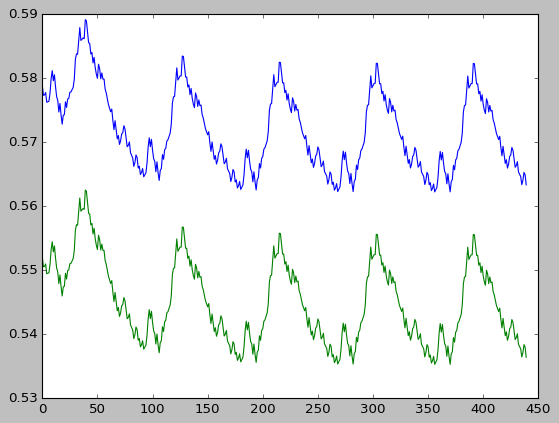

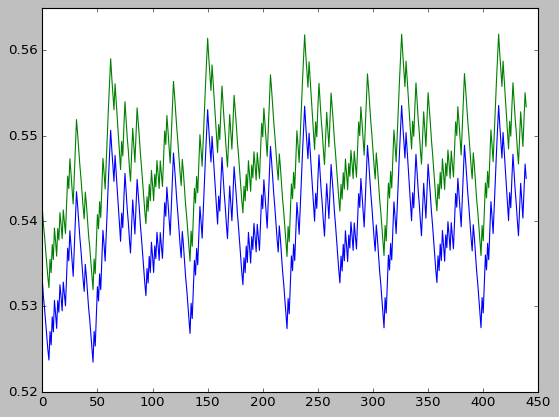

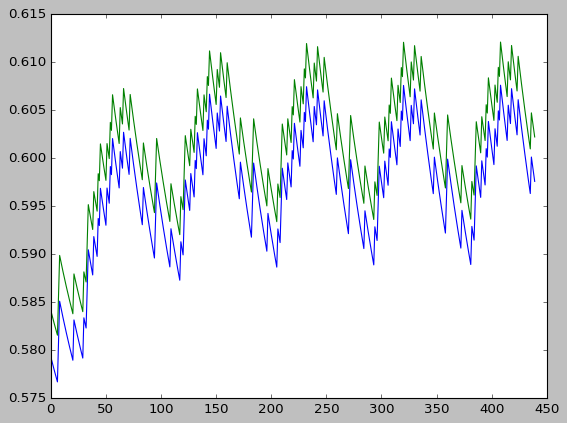

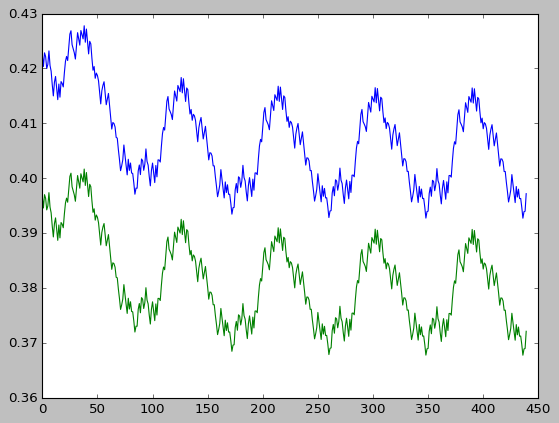

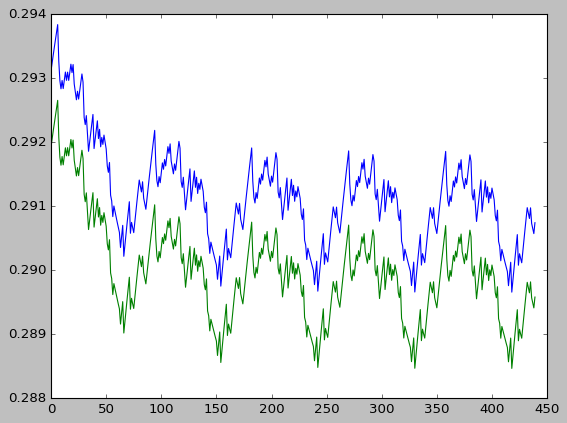

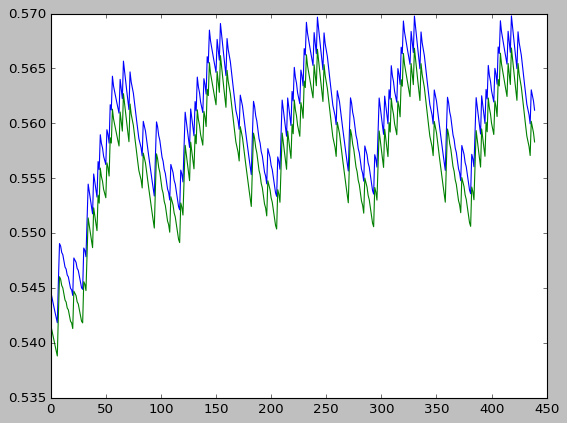

In [92]:
# for modality in modalities:
#   model = modality_models[modality.name]
#   activations = model.forward(data_trace[modality.name])
#   #activations = torch.stack(activations)
#   # trace(activation.detach())
#   #activations = activations.view(-1, activations.shape[-1])
#   #plt.plot(trace(activations.detach()).numpy())
#   plt.plot(activations.detach().numpy())
#   plt.title(modality.name)
#   plt.show()
#   plt.plot(trace(activations.detach()).numpy())
#   plt.title(f"{modality.name} trace")
#   plt.show()

new_activations = modality_models['taste'].forward(data_trace['taste'])
for i in range(original_activations.shape[-1]):
  plt.plot(original_activations[:, i].detach().numpy())
  plt.plot(new_activations[:, i].detach().numpy())
  plt.show()

In [0]:
activation_t1[0].grad